In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
import folium
import geopandas as gpd
from geopy.geocoders import Nominatim
from sklearn.cluster import DBSCAN 
import collections.abc
from collections.abc import MutableSequence 

# Plotting libraries
import plotly.express as px
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

In [2]:
app = Dash(__name__)

In [4]:
data = pd.read_csv("Cleaned Data/Cleaned_Data.csv", index_col=0, parse_dates=['CRASH DATE'])

In [5]:
data['MONTH'] = data['CRASH DATE'].dt.month
data['YEAR'] = data['CRASH DATE'].dt.year

<Axes: >

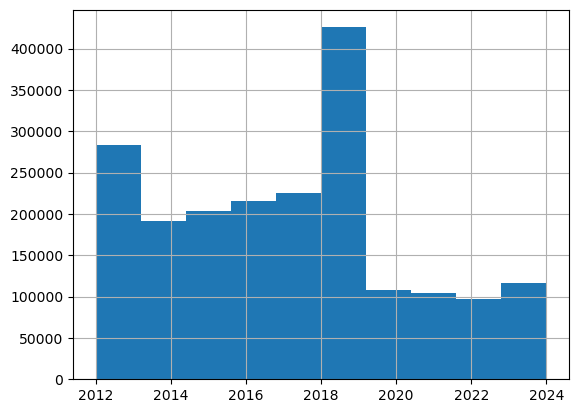

In [6]:
data['YEAR'].hist()

<Axes: >

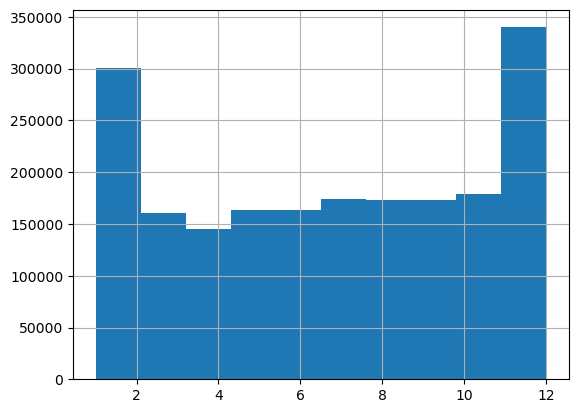

In [7]:
data['MONTH'].hist()

In [8]:
print(data[(data['NUMBER OF PERSONS KILLED'] ==0) & (data['NUMBER OF PERSONS INJURED'] == 0)].shape)
print(data.shape[0] - data[(data['NUMBER OF PERSONS KILLED'] ==0) & (data['NUMBER OF PERSONS INJURED'] == 0)].shape[0])

(1515812, 31)
455904


In [9]:
print(data[(data['NUMBER OF PERSONS KILLED'] ==0) & (data['NUMBER OF PERSONS INJURED'] == 0) & (data['NUMBER OF PEDESTRIANS INJURED'] > 0)].shape)
print(data[(data['NUMBER OF PERSONS KILLED'] ==0) & (data['NUMBER OF PERSONS INJURED'] == 0) & (data['NUMBER OF PEDESTRIANS KILLED'] > 0)].shape)
print(data[(data['NUMBER OF PERSONS KILLED'] ==0) & (data['NUMBER OF PERSONS INJURED'] == 0) & (data['NUMBER OF MOTORIST INJURED'] > 0)].shape)
print(data[(data['NUMBER OF PERSONS KILLED'] ==0) & (data['NUMBER OF PERSONS INJURED'] == 0) & (data['NUMBER OF MOTORIST KILLED'] > 0)].shape)
print(data[(data['NUMBER OF PERSONS KILLED'] ==0) & (data['NUMBER OF PERSONS INJURED'] == 0) & (data['NUMBER OF CYCLIST INJURED'] > 0)].shape)
print(data[(data['NUMBER OF PERSONS KILLED'] ==0) & (data['NUMBER OF PERSONS INJURED'] == 0) & (data['NUMBER OF CYCLIST KILLED'] > 0)].shape)

(0, 31)
(0, 31)
(0, 31)
(0, 31)
(0, 31)
(0, 31)


In [10]:
data.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'MONTH', 'YEAR'],
      dtype='object')

## Scatter plot of collisions

In [11]:
app.layout = html.Div([
    html.H4("Analysis of Crash data using scatter mapbox"),
    dcc.Dropdown(
        id="dropdown",
        options=[{'label': 'NUMBER OF PERSONS KILLED', 'value': 'NUMBER OF PERSONS KILLED'},
            {'label': 'NUMBER OF PEDESTRIANS KILLED', 'value': 'NUMBER OF PEDESTRIANS KILLED'},
            {'label': 'NUMBER OF CYCLIST KILLED', 'value': 'NUMBER OF CYCLIST KILLED'},
            {'label': 'NUMBER OF PEDESTRIANS KILLED', 'value': 'NUMBER OF PEDESTRIANS KILLED'},
            {'label': 'NUMBER OF PERSONS INJURED', 'value': 'NUMBER OF PERSONS INJURED'},
            {'label': 'NUMBER OF PEDESTRIANS INJURED', 'value':  'NUMBER OF PEDESTRIANS INJURED'},
            {'label': 'NUMBER OF CYCLIST INJURED', 'value': 'NUMBER OF CYCLIST INJURED'},
            {'label': 'NUMBER OF MOTORIST KILLED', 'value': 'NUMBER OF MOTORIST KILLED'}
        ],
        value=['NUMBER OF PEDESTRIANS KILLED'],
        multi=False
    ),
    dcc.Graph(id="accident_scattered")        
])

In [12]:
data[['LATITUDE', 'LONGITUDE', 'YEAR', 'MONTH', 'NUMBER OF PEDESTRIANS KILLED']].isna().sum()

LATITUDE                        0
LONGITUDE                       0
YEAR                            0
MONTH                           0
NUMBER OF PEDESTRIANS KILLED    0
dtype: int64

In [13]:
@app.callback(
    Output('accident_scattered', 'figure'),
    [Input('dropdown', 'value')]
)

def update_chart(selected_feature):
    df = data
    fig = px.scatter_mapbox(
        df,
        lat = 'LATITUDE',
        lon = 'LONGITUDE',
        color = 'YEAR',
        size = selected_feature,
        hover_data = ['YEAR', 'MONTH', selected_feature, 'BOROUGH'],
        zoom = 10   
    )
    return fig

In [14]:
app = Dash(__name__)

app.layout = html.Div([
    html.H4("Analysis of Crash data using scatter mapbox"),
    dcc.Dropdown(
        id="dropdown",
        options=[
            {'label': 'NUMBER OF PERSONS KILLED', 'value': 'NUMBER OF PERSONS KILLED'},
            {'label': 'NUMBER OF PEDESTRIANS KILLED', 'value': 'NUMBER OF PEDESTRIANS KILLED'},
            {'label': 'NUMBER OF CYCLIST KILLED', 'value': 'NUMBER OF CYCLIST KILLED'},
            {'label': 'NUMBER OF PERSONS INJURED', 'value': 'NUMBER OF PERSONS INJURED'},
            {'label': 'NUMBER OF PEDESTRIANS INJURED', 'value': 'NUMBER OF PEDESTRIANS INJURED'},
            {'label': 'NUMBER OF CYCLIST INJURED', 'value': 'NUMBER OF CYCLIST INJURED'},
            {'label': 'NUMBER OF MOTORIST KILLED', 'value': 'NUMBER OF MOTORIST KILLED'}
        ],
        value='NUMBER OF PEDESTRIANS KILLED',
        multi=False
    ),
    dcc.Graph(id="accident_scattered")        
])

@app.callback(
    Output('accident_scattered', 'figure'),
    [Input('dropdown', 'value')]
)
def update_chart(selected_feature):
    fig = px.scatter_mapbox(
        data,
        lat='LATITUDE',
        lon='LONGITUDE',
        color='YEAR',
        size=selected_feature,
        hover_data=['YEAR', 'MONTH', selected_feature, 'BOROUGH'],
        zoom=10
    )
    return fig


## Clustering by year

In [15]:
data_23 = data[data["YEAR"] == 2023]

